In [33]:
from Data_Import import DataImport
from sys import argv
import folium   # (https://pypi.python.org/pypi/folium)
import seaborn as sns
import pandas as pd
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
from sklearn import preprocessing, mixture


from turfpy import measurement
from geojson import Point, Feature

from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.layouts import gridplot, column, grid
from bokeh.models import DatetimeTickFormatter, ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Viridis, Cividis, Category10


from pomegranate import *

In [34]:

start_datetime =  '2021-05-13 18:00:00+00:0'
end_datetime = '2021-05-13 18:50:00+00:0' 

DataImporter = DataImport()
df = DataImporter.get_dataframe_from_gpx(fname='rutland_13_05_2021.gpx')

## treat Time
df['time_utc'] = pd.to_datetime(df['time']).dt.strftime('%H:%M:%S')
## add id
df["id"] = df.index
# filters
df = df[ df['time']>start_datetime ]
df = df[ df['time']<end_datetime]
df.head(10)




,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350
1351,52.645664,-0.634849,88.000000,2021-05-13 18:00:06+00:00,100.0,7.998761,18:00:06,1351
1352,52.645664,-0.634849,88.000000,2021-05-13 18:00:07+00:00,98.0,3.621121,18:00:07,1352
1353,52.645694,-0.634830,88.199997,2021-05-13 18:00:08+00:00,97.0,3.575458,18:00:08,1353
1354,52.645723,-0.634809,88.000000,2021-05-13 18:00:09+00:00,99.0,3.512407,18:00:09,1354
1355,52.645752,-0.634788,87.800003,2021-05-13 18:00:10+00:00,98.0,3.524433,18:00:10,1355


### Shift lat. and lnong. cols by 1 to create end data points

In [35]:
df['latitude_plus1'] = df['latitude'].shift(-1)
df['longitude_plus1'] = df['longitude'].shift(-1)

In [36]:

def calculate_initial_compass_bearing(pointA, pointB):
    """
    https://gist.github.com/jeromer/2005586
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def get_bearing(start_lat, start_long, end_lat, end_long):
    start = Feature(geometry=Point((start_lat, start_long)))
    end = Feature(geometry=Point((end_lat, end_long)))
    return measurement.bearing(start, end)

df['bearing'] = df.apply(lambda x: get_bearing(x.latitude, x.longitude, x.latitude_plus1, x.longitude_plus1), axis=1)
df['bearing'].replace(0,None, inplace=True)
df['compass_bearing'] = df.apply(lambda x: calculate_initial_compass_bearing((x.latitude, x.longitude), (x.latitude_plus1, x.longitude_plus1)), axis=1)
df['compass_bearing'].replace(0,None, inplace=True)

df['speed_SMA'] = df.speed.rolling(2, min_periods=1).mean()

print('max sma speed:', df.speed_SMA.max())
print('max speed:', df.speed.max())


max sma speed: 13.875597613639101
max speed: 16.594576583587397


In [37]:
def wgs84_to_web_mercator(df, lon="LON", lat="LAT"):
      k = 6378137
      df["x"] = df['longitude'] * (k * np.pi/180.0)
      df["y"] = np.log(np.tan((90 + df['latitude']) * np.pi/360.0)) * k
      return df

wgs84_to_web_mercator(df)

,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id,latitude_plus1,longitude_plus1,bearing,compass_bearing,speed_SMA,x,y
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346,52.645476,-0.634872,106.700213,349.079548,4.558620,-70672.256221,6.917681e+06
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347,52.645518,-0.634883,104.677256,351.085574,4.594188,-70673.674486,6.917688e+06
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348,52.645558,-0.634885,92.862581,358.407067,4.618745,-70674.878146,6.917696e+06
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349,52.645594,-0.634879,80.537108,6.106820,4.440793,-70675.083421,6.917703e+06
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350,52.645664,-0.634849,66.800136,14.682522,5.148972,-70674.374288,6.917710e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,52.643314,-0.634387,85.400002,2021-05-13 18:49:55+00:00,97.0,3.595186,18:49:55,4262,52.643300,-0.634425,-159.776280,239.991192,4.152270,-70619.659111,6.917291e+06
4263,52.643300,-0.634425,85.199997,2021-05-13 18:49:56+00:00,97.0,2.814301,18:49:56,4263,52.643293,-0.634463,-169.563151,252.662335,3.204744,-70623.839261,6.917289e+06
4264,52.643293,-0.634463,85.199997,2021-05-13 18:49:57+00:00,97.0,2.852372,18:49:57,4264,52.643291,-0.634507,-177.397597,265.023988,2.833337,-70628.075395,6.917287e+06
4265,52.643291,-0.634507,85.199997,2021-05-13 18:49:58+00:00,97.0,2.987993,18:49:58,4265,52.643295,-0.634551,174.805888,278.326286,2.920183,-70633.020662,6.917287e+06


In [38]:
'''Calculate phase '''
df['angle_from_mean'] = df['bearing'] - df['bearing'].mean()
df['abs_angle_from_mean'] = df['angle_from_mean'].abs()
df['phase'] = np.where(df['angle_from_mean'].abs()<100, 'upwind','downwind')

,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id,latitude_plus1,longitude_plus1,...,speed_SMA,x,y,angle_from_mean,abs_angle_from_mean,phase,speed_norm,angle_from_true,tack,angle_of_sail
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346,52.645476,-0.634872,...,4.558620,-70672.256221,6.917681e+06,85.979254,85.979254,upwind,0.274705,349.079548,reach,reach
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347,52.645518,-0.634883,...,4.594188,-70673.674486,6.917688e+06,83.956297,83.956297,upwind,0.278992,351.085574,reach,reach
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348,52.645558,-0.634885,...,4.618745,-70674.878146,6.917696e+06,72.141622,72.141622,upwind,0.277665,358.407067,reach,reach
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349,52.645594,-0.634879,...,4.440793,-70675.083421,6.917703e+06,59.816149,59.816149,upwind,0.257545,6.106820,upwind,upwind
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350,52.645664,-0.634849,...,5.148972,-70674.374288,6.917710e+06,46.079178,46.079178,upwind,0.363016,14.682522,upwind,upwind
1351,52.645664,-0.634849,88.000000,2021-05-13 18:00:06+00:00,100.0,7.998761,18:00:06,1351,52.645664,-0.634849,...,7.011427,-70671.033901,6.917722e+06,46.079178,46.079178,upwind,0.482011,14.682522,upwind,upwind
1352,52.645664,-0.634849,88.000000,2021-05-13 18:00:07+00:00,98.0,3.621121,18:00:07,1352,52.645694,-0.634830,...,5.809941,-70671.033901,6.917722e+06,36.930008,36.930008,upwind,0.218211,20.054375,upwind,upwind
1353,52.645694,-0.634830,88.199997,2021-05-13 18:00:08+00:00,97.0,3.575458,18:00:08,1353,52.645723,-0.634809,...,3.598290,-70668.990479,6.917728e+06,33.367648,33.367648,upwind,0.215459,24.384428,upwind,upwind
1354,52.645723,-0.634809,88.000000,2021-05-13 18:00:09+00:00,99.0,3.512407,18:00:09,1354,52.645752,-0.634788,...,3.543933,-70666.592491,6.917733e+06,33.367648,33.367648,upwind,0.211660,24.235505,upwind,upwind
1355,52.645752,-0.634788,87.800003,2021-05-13 18:00:10+00:00,98.0,3.524433,18:00:10,1355,52.645782,-0.634771,...,3.518420,-70664.231826,6.917739e+06,39.738751,39.738751,upwind,0.212385,18.319828,upwind,upwind


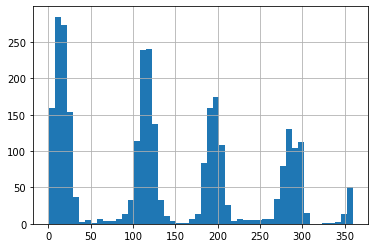

In [79]:
''' Calc True Wind angle, do calcs in radian of rhandle degrees'''
assumed_true_wind_angle = 50
df['angle_from_true'] = df['compass_bearing']#- assumed_true_wind_angle


def angle_of_sail(data: pd.DataFrame):
    if abs(data['angle_from_true'])<60: return 'upwind'
    elif (abs(data['angle_from_true'])>60) & (abs(data['angle_from_true'])>150): return 'reach'
    else: return 'downwind'

# filter = df['phase']=='upwind'
df['angle_of_sail'] = df.apply(angle_of_sail, axis=1)


df['angle_from_true'].hist(bins=50)
df.head(10)

In [39]:
## normalise
x = df['speed'].values #returns a numpy array
x = x.reshape(-1, 1) # reshape as just have a single feature here
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['speed_norm'] = x_scaled
len(df)

2921

In [23]:
## differentiate angle 
import datetime
df['diff_abs_angle_from_mean'] = df['abs_angle_from_mean'].diff()
df['diff_time'] = df['time'].diff() / np.timedelta64(1, 's')
#df['diff_time']  = df['diff_time']/ np.timedelta64(1, 's')
df['ddt_abs_angle_from_mean'] = df['diff_abs_angle_from_mean'] / df['diff_time']
df.head(5)

,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id,latitude_plus1,longitude_plus1,...,speed_SMA,x,y,angle_from_mean,abs_angle_from_mean,phase,speed_norm,diff_abs_angle_from_mean,diff_time,ddt_abs_angle_from_mean
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346,52.645476,-0.634872,...,4.558620,-70672.256221,6.917681e+06,85.979254,85.979254,upwind,0.274705,NaN,NaN,NaN
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347,52.645518,-0.634883,...,4.594188,-70673.674486,6.917688e+06,83.956297,83.956297,upwind,0.278992,-2.022957,1.0,-2.022957
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348,52.645558,-0.634885,...,4.618745,-70674.878146,6.917696e+06,72.141622,72.141622,upwind,0.277665,-11.814675,1.0,-11.814675
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349,52.645594,-0.634879,...,4.440793,-70675.083421,6.917703e+06,59.816149,59.816149,upwind,0.257545,-12.325473,1.0,-12.325473
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350,52.645664,-0.634849,...,5.148972,-70674.374288,6.917710e+06,46.079178,46.079178,upwind,0.363016,-13.736971,1.0,-13.736971


In [24]:

#output_notebook()

x = df['time'].tolist()
y0 = df['x']
y1 = df['y']
y2 = df['speed'].tolist()
y3 = df['speed_norm'].tolist()
y4 = df['bearing'].tolist()
y5 = df['compass_bearing'].tolist()
y6 = df['angle_from_mean'].tolist()
c0 = df['bearing'].mean()*np.ones(len(y3))
c0 = c0.tolist()
phase = df['phase']



# create a column data source for the plots to share
source = ColumnDataSource(data=dict(x=x, y0=y0, y1=y1, y2=y2, y3=y3, y4=y4, y5=y5, y6=y6, c0=c0, phase=phase))

pal = Category10[3]
colors = factor_cmap('phase', palette=pal, factors=['upwind','downwind','None']) 

TOOLS = "box_select,lasso_select,help"

tile_provider = get_provider(CARTODBPOSITRON)

# range bounds supplied in web mercator coordinates
p1 = figure(x_range=(df['x'].min(), df['x'].max()), y_range=(df['y'].min(), df['y'].max()),
           x_axis_type="mercator", y_axis_type="mercator", plot_width=1200, plot_height=600)
p1.add_tile(tile_provider)

p1.circle('y0', 'y1', legend_label="track.", line_width=1, source=source, color=colors)


# speed
p2 = figure(tools=TOOLS, plot_width=600, plot_height=300, title='speed')
p2.circle('x', 'y2', source=source)
p2.xaxis.formatter=DatetimeTickFormatter(
    days=["%m/%d %H:%M:%S"],
    months=["%m/%d %H:%M:%S"],
    hours=["%m/%d %H:%M:%S"],
    minutes=["%m/%d %H:%M:%S"]
)
p2.xaxis.major_label_orientation = pi/4

# angle_from_mean
p3 = figure(tools=TOOLS, plot_width=600, plot_height=300, title='angle_from_mean')
p3.circle('x', 'y6', source=source)
#p3.line('x' , 'c0', source=source, color='red', width=1.5,line_dash='dashed')
p3.xaxis.formatter=DatetimeTickFormatter(
    days=["%m/%d %H:%M:%S"],
    months=["%m/%d %H:%M:%S"],
    hours=["%m/%d %H:%M:%S"],
    minutes=["%m/%d %H:%M:%S"]
)
p3.xaxis.major_label_orientation = pi/4

p = grid([[p2, p3], [p1]])

show(p)

In [25]:
print(df['bearing'].mean())
print(df['compass_bearing'].mean())

20.720958791712928
134.5940962089346


array([<AxesSubplot:title={'center':'abs_angle_from_mean'}>], dtype=object)

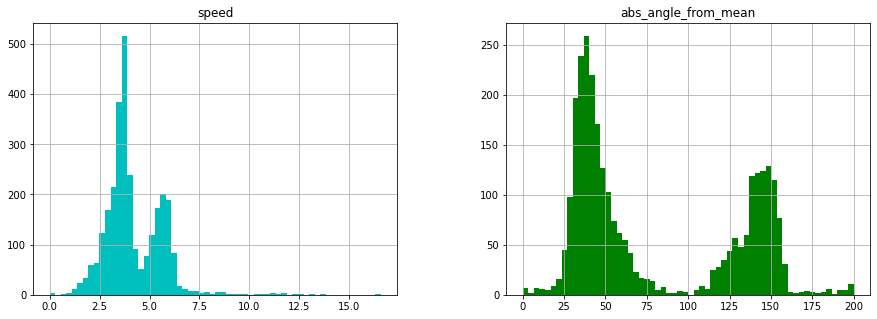

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df.hist(ax=axes[0], column='speed', bins=60, color='c')
df.hist(ax=axes[1], column='abs_angle_from_mean', bins=60, color='g')
#hist = df.hist(column='speed_norm', bins=60, color='c')

59.22977804903175
57.993598001219056


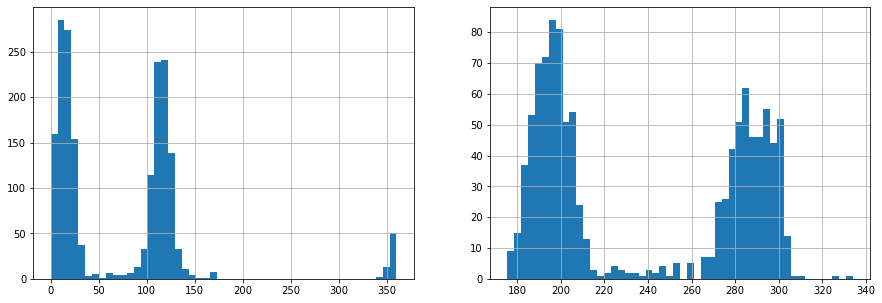

In [65]:
'''Find Average Wind direction'''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))


a = df[df['phase']=='upwind']['compass_bearing']
a.hist(ax=axes[0], bins=50)
print(np.median(a))


b = df[df['phase']=='downwind']['compass_bearing']
b.hist(ax=axes[1], bins=50)
print(np.mean(b)-180)

In [31]:
speed = df['speed'].to_numpy()
speed_filtered = speed[~np.isnan(speed)]
speed_filtered = speed_filtered.reshape(-1,1)
gmm_speed = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(speed_filtered)
means_speed = gmm_speed.means_
vars_speed = np.sqrt(gmm_speed.covariances_)

speed_stats = pd.DataFrame({'means':means_speed.flatten(), 'vars':vars_speed.flatten()})
speed_stats = speed_stats.sort_values(by=['means'], ascending=True).reset_index(drop=True)
print(speed_stats)



angle = df['abs_angle_from_mean'].to_numpy()
angle_filtered = angle[~np.isnan(angle)]
angle_filtered = angle_filtered.reshape(-1,1)
gmm_angle = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(angle_filtered)
means_angle = gmm_angle.means_
vars_angle = np.sqrt(gmm_angle.covariances_)

angle_stats = pd.DataFrame({'means':means_angle.flatten(), 'vars':vars_angle.flatten()})
angle_stats = angle_stats.sort_values(by=['means'], ascending=True).reset_index(drop=True)
print(angle_stats)



#gmm = GeneralMixtureModel.from_samples(NormalDistribution, 2, data, verbose=True)

      means      vars
0  3.519486  0.378628
1  4.587983  1.673880
        means       vars
0   42.522742  12.601309
1  141.836005  15.448106


In [14]:
''' Find Wind direction '''
initial_wind_estimate = 360
df['wind_direction_vs_course'] = initial_wind_estimate - df['compass_bearing']
df

,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id,latitude_plus1,longitude_plus1,...,x,y,angle_from_mean,abs_angle_from_mean,phase,speed_norm,diff_abs_angle_from_mean,diff_time,ddt_abs_angle_from_mean,wind_direction_vs_course
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346,52.645476,-0.634872,...,-70672.256221,6.917681e+06,85.979254,85.979254,upwind,0.274705,NaN,NaN,NaN,10.920452
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347,52.645518,-0.634883,...,-70673.674486,6.917688e+06,83.956297,83.956297,upwind,0.278992,-2.022957,1.0,-2.022957,8.914426
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348,52.645558,-0.634885,...,-70674.878146,6.917696e+06,72.141622,72.141622,upwind,0.277665,-11.814675,1.0,-11.814675,1.592933
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349,52.645594,-0.634879,...,-70675.083421,6.917703e+06,59.816149,59.816149,upwind,0.257545,-12.325473,1.0,-12.325473,353.893180
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350,52.645664,-0.634849,...,-70674.374288,6.917710e+06,46.079178,46.079178,upwind,0.363016,-13.736971,1.0,-13.736971,345.317478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,52.643314,-0.634387,85.400002,2021-05-13 18:49:55+00:00,97.0,3.595186,18:49:55,4262,52.643300,-0.634425,...,-70619.659111,6.917291e+06,-180.497239,180.497239,downwind,0.216648,14.104862,1.0,14.104862,120.008808
4263,52.643300,-0.634425,85.199997,2021-05-13 18:49:56+00:00,97.0,2.814301,18:49:56,4263,52.643293,-0.634463,...,-70623.839261,6.917289e+06,-190.284109,190.284109,downwind,0.169592,9.786871,1.0,9.786871,107.337665
4264,52.643293,-0.634463,85.199997,2021-05-13 18:49:57+00:00,97.0,2.852372,18:49:57,4264,52.643291,-0.634507,...,-70628.075395,6.917287e+06,-198.118556,198.118556,downwind,0.171886,7.834447,1.0,7.834447,94.976012
4265,52.643291,-0.634507,85.199997,2021-05-13 18:49:58+00:00,97.0,2.987993,18:49:58,4265,52.643295,-0.634551,...,-70633.020662,6.917287e+06,154.084929,154.084929,downwind,0.180058,-44.033627,1.0,-44.033627,81.673714


In [ ]:
''' ### Initialise Model ### '''
hmm = HiddenMarkovModel()

''' ### Set Emission Probabilities ### '''
# # based on angle 
upwind_probs = NormalDistribution(angle_stats.means[0], angle_stats.vars[0])
downwind_probs = NormalDistribution(angle_stats.means[1], angle_stats.vars[1])
# upwind_probs_angle = NormalDistribution(angle_stats.means[0], angle_stats.vars[0])
# downwind_probs_angle = NormalDistribution(angle_stats.means[1], angle_stats.vars[1])
# upwind_probs_angle = DiscreteDistribution({0:0.30, 40:0.40, 80:0.20, 120:0.10, 160:0.0, 200:0.0})
# downwind_probs_angle = DiscreteDistribution({0:0.0, 40:0.0, 80:0.0, 120:0.40, 160:0.50, 200:0.10})

# based on speed
# upwind_probs = NormalDistribution(speed_stats.means[0], speed_stats.vars[0])
# downwind_probs = NormalDistribution(speed_stats.means[1], speed_stats.vars[1])
# upwind_probs_speed = NormalDistribution(speed_stats.means[0], speed_stats.vars[0])
# downwind_probs_speed = NormalDistribution(speed_stats.means[1], speed_stats.vars[1])
# upwind_probs_speed = DiscreteDistribution({0:0.30, 3:0.40, 6:0.20, 9:0.10, 12:0.0, 15:0.0})
# downwind_probs_speed = DiscreteDistribution({0:0.0, 3:0.10, 6:0.20, 9:0.30, 12:0.20, 15:0.20})

# upwind_probs = IndependentComponentsDistribution([upwind_probs_angle, upwind_probs_speed])
# downwind_probs = IndependentComponentsDistribution([downwind_probs_angle, downwind_probs_speed])

upwind  = State(upwind_probs , name='upwind' )
downwind = State(downwind_probs, name='downwind')

hmm.add_states(upwind, downwind)

''' ### Set Transition probabilities ### '''
hmm.add_transition( hmm.start, upwind, 0.5 )
hmm.add_transition( hmm.start, downwind, 0.5 )
hmm.add_transition( upwind, upwind, 0.8 )
hmm.add_transition( upwind, downwind, 0.2 )
hmm.add_transition( downwind, upwind, 0.2 )
hmm.add_transition( downwind, downwind, 0.8 )

''' ### Bake model ### '''
hmm.bake()


In [ ]:
#seq = df[['abs_angle_from_mean', 'speed']].to_numpy()
seq = df[['abs_angle_from_mean']].to_numpy()
#seq = seq.astype(str)
seq

array([[ 85.97925378],
       [ 83.95629672],
       [ 72.1416221 ],
       ...,
       [198.11855595],
       [154.08492911],
       [         nan]])

In [ ]:
hmm_predictions = hmm.predict( seq )
posteria_probs = hmm.predict_proba( seq )
df['phase_predictions'] = np.array(hmm_predictions)
#df_filt['posteria_probs'] = np.array(posteria_probs)
# print(len(hmm_predictions))
# print(len(df))
df.head(5)

,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id,latitude_plus1,longitude_plus1,bearing,compass_bearing,speed_SMA,x,y,angle_from_mean,abs_angle_from_mean,phase,speed_norm,phase_predictions
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346,52.645476,-0.634872,106.700213,349.079548,4.558620,-70672.256221,6.917681e+06,85.979254,85.979254,upwind,0.274705,1
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347,52.645518,-0.634883,104.677256,351.085574,4.594188,-70673.674486,6.917688e+06,83.956297,83.956297,upwind,0.278992,1
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348,52.645558,-0.634885,92.862581,358.407067,4.618745,-70674.878146,6.917696e+06,72.141622,72.141622,upwind,0.277665,1
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349,52.645594,-0.634879,80.537108,6.106820,4.440793,-70675.083421,6.917703e+06,59.816149,59.816149,upwind,0.257545,1
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350,52.645664,-0.634849,66.800136,14.682522,5.148972,-70674.374288,6.917710e+06,46.079178,46.079178,upwind,0.363016,1


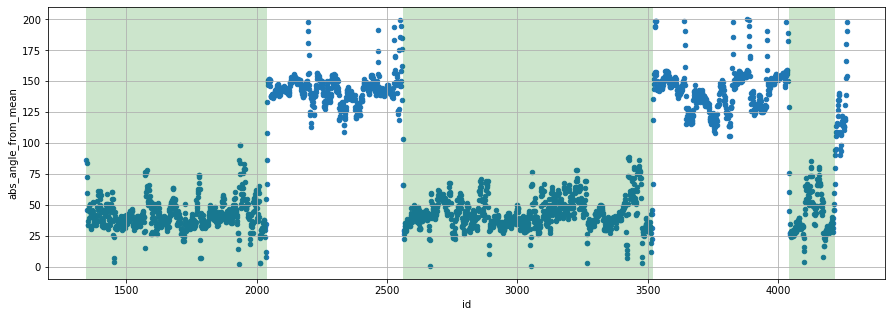

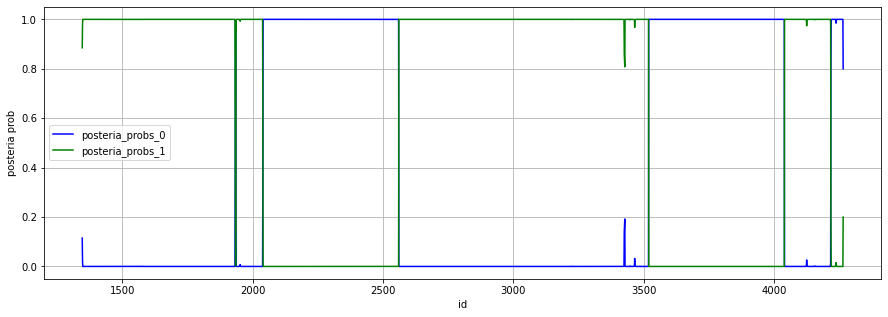

In [ ]:
df['phase_prediction'] = hmm_predictions
df['posteria_probs_0'] = posteria_probs[:,0]
df['posteria_probs_1'] = posteria_probs[:,1]

ax =  df.plot(x = 'id', y='abs_angle_from_mean',kind='scatter',figsize=[15,5])
downwind_times = df[df.phase_prediction==1].index
for i in downwind_times:
    ax.axvspan(i,i+1, facecolor='green', edgecolor='none', alpha=.2)
plt.grid()

plt.figure()
ax1 = plt.gca()
df.plot(x = 'id', y='posteria_probs_0', kind='line', figsize=[15,5], ax=ax1, color='blue')
df.plot(x = 'id', y='posteria_probs_1', kind='line', figsize=[15,5], ax=ax1, color='green')
ax1.set_ylabel("posteria prob")
plt.grid()



Text(0, 0.5, 'probability')

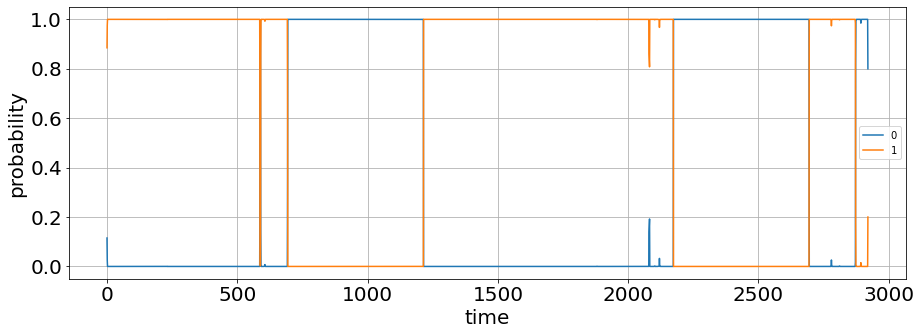

In [ ]:
ax = pd.DataFrame(hmm.predict_proba( seq )).plot(figsize=[15,5],fontsize=20)
plt.grid()
plt.xlabel('time',fontsize=20)
plt.ylabel('probability',fontsize=20)

In [ ]:
df.head(5)

,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id,latitude_plus1,longitude_plus1,...,x,y,angle_from_mean,abs_angle_from_mean,phase,speed_norm,phase_predictions,phase_prediction,posteria_probs_0,posteria_probs_1
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346,52.645476,-0.634872,...,-70672.256221,6.917681e+06,85.979254,85.979254,upwind,0.274705,1,1,1.150655e-01,0.884935
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347,52.645518,-0.634883,...,-70673.674486,6.917688e+06,83.956297,83.956297,upwind,0.278992,1,1,2.499279e-02,0.975007
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348,52.645558,-0.634885,...,-70674.878146,6.917696e+06,72.141622,72.141622,upwind,0.277665,1,1,4.221985e-05,0.999958
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349,52.645594,-0.634879,...,-70675.083421,6.917703e+06,59.816149,59.816149,upwind,0.257545,1,1,9.894278e-08,1.000000
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350,52.645664,-0.634849,...,-70674.374288,6.917710e+06,46.079178,46.079178,upwind,0.363016,1,1,2.406092e-10,1.000000


In [ ]:
df.to_csv('df.csv')

In [ ]:
len(df)

2921